Hannah Lo, Henry Spinella, Kelsey Olesen


In [1]:
#importing libraries and data, examining data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

gov_df = pd.read_csv("data/governors_county_candidate.csv")
pres_df = pd.read_csv("data/president_county_candidate.csv")

nrows_gov, ncols_gov = gov_df.shape
nrow_pres, ncols_pres = pres_df.shape

print("# of rows in governor dataset:", nrows_gov)
print("# of columns:", ncols_gov)

print("# of rows in president dataset:", nrow_pres)
print("# of columns:", ncols_pres)

print(gov_df.columns.values)
print(pres_df.columns.values)

print(gov_df.dtypes)
print(pres_df.dtypes) #we did not have to change the data type of any of these columns

# of rows in governor dataset: 5145
# of columns: 6
# of rows in president dataset: 32177
# of columns: 6
['state' 'county' 'candidate' 'party' 'votes' 'won']
['state' 'county' 'candidate' 'party' 'total_votes' 'won']
state        object
county       object
candidate    object
party        object
votes         int64
won            bool
dtype: object
state          object
county         object
candidate      object
party          object
total_votes     int64
won              bool
dtype: object


In [2]:
#cleaning data where no one wrote in a candidate even though they selected Write-In aka blank ballots
#dont want to include this in our analysis because it doesn't help us understand any differences
clean_gov_df = gov_df.query("candidate != ' Write-ins' | votes != 0")
clean_pres_df = pres_df.query("candidate != ' Write-ins' | total_votes != 0").copy() #python threw an error  during renaming when i didn't make this an explicit copy

#also renaming clean_pres column total_votes into votes for ease of understanding

clean_pres_df.rename(columns={'total_votes' : 'votes'}, inplace=True)
clean_pres_df.columns



Index(['state', 'county', 'candidate', 'party', 'votes', 'won'], dtype='object')

In [3]:
print(pres_winners)

NameError: name 'pres_winners' is not defined

Merging and Aggregating

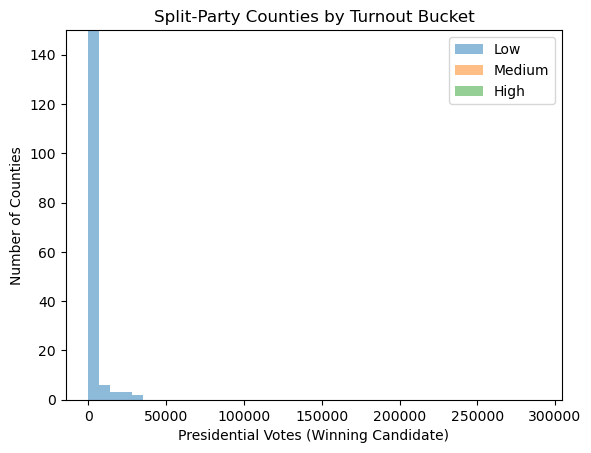

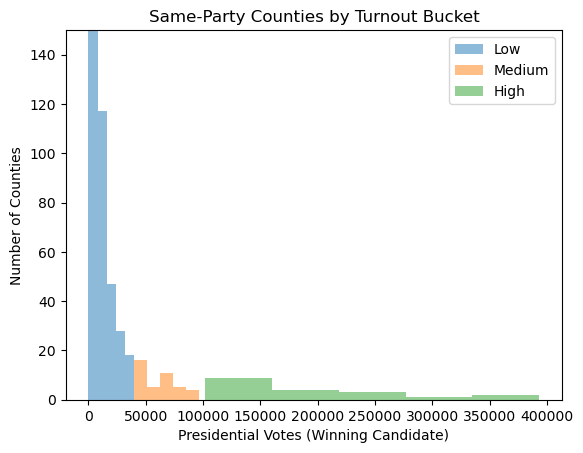

In [ ]:
gov_by_county = clean_gov_df.groupby(['state', 'county'], as_index=False)['votes'].sum()
pres_by_county = clean_pres_df.groupby(['state', 'county'], as_index=False)['votes'].sum() #grouping the data makes state and county indexes unless we use as_index = false

gov_winners = clean_gov_df[clean_gov_df['won']].copy()
pres_winners = clean_pres_df[clean_pres_df['won']].copy()

merged_data = gov_winners.merge(
    pres_winners,
    on=['state', 'county'],
    suffixes=('_gov', '_pres')
)

merged_data['party_eq'] = merged_data['party_gov'] == merged_data['party_pres']


bins = [0, 40000, 100000, 900000]
labels = ['Low', 'Medium', 'High']

merged_data['vote_bucket'] = pd.cut(
    merged_data['votes_pres'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

split = merged_data[merged_data['party_eq'] == False]


for bucket in labels:
    subset = split[split['vote_bucket'] == bucket]

    plt.hist(
        subset['votes_pres'],
        bins=5,
        alpha=0.5,
        label= bucket
    )
plt.xlabel("Presidential Votes (Winning Candidate)")
plt.ylabel("Number of Counties")
plt.title("Split-Party Counties by Turnout Bucket")
plt.ylim(0, 150)  
plt.legend()
plt.show()

same = merged_data[merged_data['party_eq'] == True]
for bucket in labels:
    subset = same[same['vote_bucket'] == bucket]

    plt.hist(
        subset['votes_pres'],
        bins=5,
        alpha=0.5,
        label=bucket
    )

plt.xlabel("Presidential Votes (Winning Candidate)")
plt.ylabel("Number of Counties")
plt.title("Same-Party Counties by Turnout Bucket")
plt.ylim(0, 150)  
plt.legend()
plt.show()

#more less populated counties in the split-party subset compared to the same-party

In each county, how strongly is the governor’s winning vote share correlated with the president’s winning vote share?

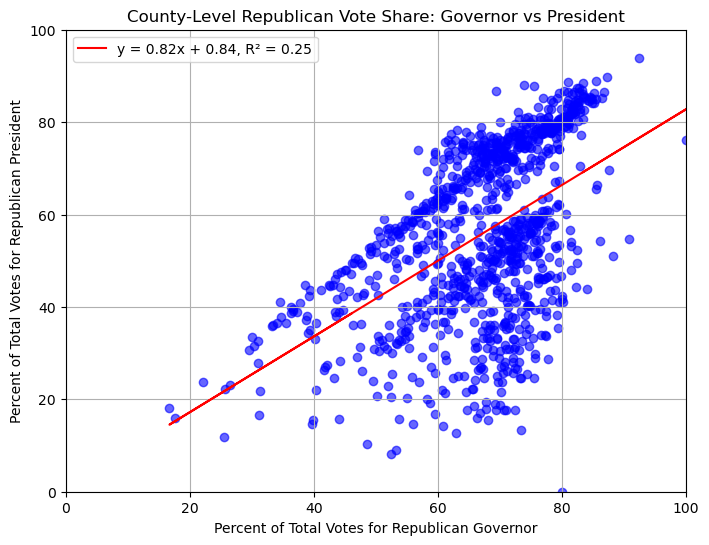

In [ ]:
import matplotlib.pyplot as plt

# Sum Republican votes per county
gov_R_votes = clean_gov_df[clean_gov_df['party'] == 'REP'].groupby(['state','county'], as_index=False)['votes'].sum()
pres_R_votes = clean_pres_df[clean_pres_df['party'] == 'REP'].groupby(['state','county'], as_index=False)['votes'].sum()

# Merge Republican votes and total votes per county
merged_votes = gov_by_county.rename(columns={'votes':'gov_total_votes'}).merge(
    gov_R_votes.rename(columns={'votes':'gov_R_votes'}),
    on=['state','county']
).merge(
    pres_by_county.rename(columns={'votes':'pres_total_votes'}),
    on=['state','county']
).merge(
    pres_R_votes.rename(columns={'votes':'pres_R_votes'}),
    on=['state','county']
)

# Compute true Republican vote share
merged_votes['gov_R_share'] = merged_votes['gov_R_votes'] / merged_votes['gov_total_votes']
merged_votes['pres_R_share'] = merged_votes['pres_R_votes'] / merged_votes['pres_total_votes']

# Scatter plot: each point = one county
x = merged_votes['gov_R_share']*100
y = merged_votes['pres_R_share']*100
plt.figure(figsize=(8,6))
plt.scatter(
    x,
    y,
    alpha=0.6,
    color='blue'
)

# Fit linear regression
slope, intercept = np.polyfit(x, y, 1)
line_y = slope * x + intercept

# Calculate R^2
correlation_matrix = np.corrcoef(x, y)
r_value = correlation_matrix[0,1]
r_squared = r_value**2

# Plot line with equation and R^2 in legend
plt.plot(x, line_y, color='red', label=f'y = {slope:.2f}x + {intercept:.2f}, R² = {r_squared:.2f}')

# Set axes range from 0 to 100
plt.xlim(0, 100)
plt.ylim(0, 100)

# Labels and title
plt.xlabel("Percent of Total Votes for Republican Governor")
plt.ylabel("Percent of Total Votes for Republican President")
plt.title("County-Level Republican Vote Share: Governor vs President")
plt.grid(True)
plt.legend()
plt.show()


Descriptive Statistics

In [81]:
desc_stats = merged_data[['votes_gov', 'votes_pres']].describe()
print(desc_stats)

           votes_gov     votes_pres
count    1025.000000    1025.000000
mean    12487.689756   12695.991220
std     42228.752855   42922.320095
min         4.000000       5.000000
25%       742.000000     682.000000
50%      2663.000000    2575.000000
75%      9076.000000    9573.000000
max    887374.000000  907310.000000
